In [1]:
import sys

import glob
from glow.builder import build
from glow.config import JsonConfig
import glow.utils

from glow.dataset import Speech2FaceDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from os.path import basename, join
import numpy as np
from luigi_pipeline.audio_processing import MelSpectrogram
from luigi_pipeline.post_process_openpose import PostProcessOpenpose
from luigi_pipeline.post_process_openface import PostProcessOpenface
from luigi_pipeline.youtube_downloader import DownloadYoutubeAudio
from luigi_pipeline.openface import Openface
import luigi
from multiprocessing import cpu_count
from Speech2Face import utils
from collections import defaultdict
import time
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import scipy.io
import librosa.display
import librosa
import requests
import json
import tempfile
import os
import shutil
import pandas as pd

In [2]:
hparams_path = 'hparams/speech2face_cpu.json'
yt_video_ids = ["MS5UjNKw_1M"]
data_dir = '/Users/pj/phd/projects/word2face/code/data_dir'
checkpoint_path = '/Users/pj/phd/projects/word2face/code/glow/trained.pkg'
video_length = 160
FPS = 30

In [3]:
hparams = JsonConfig(hparams_path)
model = build(hparams, False)['graph']
_ = model.eval()

[Checkpoint]: Load ./results/speech2face/trained.pkg successfully
[Builder]: Use cpu to train.


In [ ]:
# checkpoint_model = torch.load(checkpoint_path, map_location='cpu')
# print(checkpoint_model.keys())
# model.load_state_dict(checkpoint_model['graph'])


In [3]:
luigi_tasks = []
for yt_video_id in yt_video_ids:
    luigi_tasks.append(MelSpectrogram(yt_video_id=yt_video_id, data_dir=data_dir, hop_length=540, sampling_rate=16200, n_fft=540))
#     luigi_tasks.append(PostProcessOpenface(yt_video_id=yt_video_id, data_dir=data_dir))

luigi.build(luigi_tasks, workers=cpu_count(), log_level="WARNING", local_scheduler=True)

INFO:luigi:logging configured by default settings


True

In [6]:
# dataset = Speech2FaceDataset(data_dir=data_dir, total_frames=video_length, audio_feature_type='spectrogram')

In [21]:
# data_loader = DataLoader(
#     dataset,
#     batch_size=hparams.Train.batch_size,
# #    shuffle=True,
# )

In [21]:
import random
random.randint(0, 12)

2

In [4]:
# new_clip = np.load(MelSpectrogram(yt_video_id=yt_video_id, data_dir=data_dir, hop_duration=0.033).output().path)
old_clip = np.load(MelSpectrogram(yt_video_id=yt_video_ids[0], data_dir=data_dir, hop_duration=0.033).output().path)
yt_audio_path = DownloadYoutubeAudio(yt_video_id=yt_video_ids[0], data_dir=data_dir).output().path

start_position = 200
end_position = start_position + hparams.Glow.spec_frames

y___, sr___ = librosa.load(yt_audio_path, sr=16000, mono=True)

dbb = torch.from_numpy(old_clip[start_position:end_position].T).unsqueeze(0).float().expand(hparams.Train.batch_size, -1, -1)

new_old_img = model(audio_features=dbb, reverse=True)


In [17]:
# librosa.display.specshow(old_clip[start_position:end_position].T, y_axis='log')
def calc_au(x):
    if x < 1:
        x = 0
    return min(round(x / 4, 4), 1)
frames = []
import math
for i, x in enumerate(new_old_img[0].cpu().detach().numpy().transpose(1, 0, 2)):
    AU01_r, AU02_r, AU04_r, AU45_r, pose_Rx, pose_Ry, pose_Rz, _ = x
    AU01_r, AU02_r, AU04_r, AU45_r, pose_Rx, pose_Ry, pose_Rz = (
        float(AU01_r[0]),
        float(AU02_r[0]),
        float(AU04_r[0]),
        float(AU45_r[0]),
        float(pose_Rx[0]),
        float(pose_Ry[0]),
        float(pose_Rz[0]),
    )

    
    frames.append({
        "time": [i*0.033],
        "persist": False,
        "params":{
            "BROW_IN_LEFT": calc_au(AU01_r),
            "BROW_IN_RIGHT": calc_au(AU01_r),
            "BROW_UP_LEFT": calc_au(AU02_r),
            "BROW_UP_RIGHT": calc_au(AU02_r),
            "BROW_DOWN_LEFT": calc_au(AU04_r),
            "BROW_DOWN_RIGHT": calc_au(AU04_r),
            "BLINK_LEFT": calc_au(AU45_r),
            "BLINK_RIGHT": calc_au(AU45_r),
            "NECK_ROLL": math.degrees(pose_Rx) * -1,
            "NECK_TILT": math.degrees(pose_Ry) * -1,
            "NECK_PAN": math.degrees(pose_Rz) * -1,
        }
    })
# import csv

aaaaa = {
    "class":"furhatos.gestures.Gesture",
    "frames": frames
}
with open("/Users/pj/phd/projects/word2face/code/glow/blendshapes.json", 'w') as f:    
    json.dump(aaaaa, f)
#     csv_writer = csv.writer(f)
#     csv_writer.writerow([
#         "BROW_IN_LEFT", "BROW_IN_RIGHT", "BROW_UP_LEFT", "BROW_UP_RIGHT", "BROW_DOWN_LEFT", "BROW_DOWN_RIGHT", "BLINK_LEFT", "BLINK_RIGHT", "NECK_ROLL", "NECK_TILT", "NECK_PAN" 
#     ])
#     csv_writer.writerows(all_of_it)

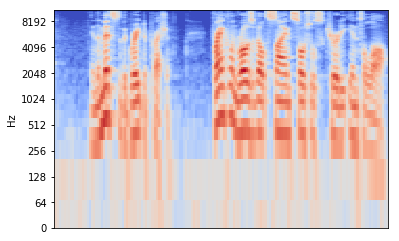

In [7]:
librosa.display.specshow(old_clip[start_position:end_position].T, y_axis='log')

In [52]:
vr = VideoRender(render_url='http://localhost:5000')
vr.render('/Users/pj/phd/projects/word2face/code/glow/new_video.mp4', new_old_img[0].cpu().detach().numpy().transpose(1, 0, 2), yt_audio_path, '', start_position)

[-0.061393626034259796, 0.21980583667755127, -0.127581387758255]
[-0.06519278883934021, 0.20201902091503143, -0.10282661765813828]
[-0.010135967284440994, 0.16566947102546692, -0.08714520186185837]
[-0.013028055429458618, 0.13166092336177826, -0.09335440397262573]
[-0.009206298738718033, 0.10695435106754303, -0.09566640108823776]
[-0.011829465627670288, 0.08108171820640564, -0.08012062311172485]
[0.004723984748125076, 0.06454001367092133, -0.07869455218315125]
[0.02041444182395935, 0.06895335018634796, -0.07211659103631973]
[0.021947672590613365, 0.049318261444568634, -0.05209675058722496]
[0.019606806337833405, 0.04434735327959061, -0.04451420158147812]
[0.022648239508271217, 0.034352824091911316, -0.04325775429606438]
[0.0010176151990890503, 0.03084244392812252, -0.03144467622041702]
[-0.005620185285806656, 0.007147639989852905, -0.019040465354919434]
[-0.018313542008399963, 0.011583274230360985, -0.012703744694590569]
[-0.03781568259000778, 0.02089224010705948, -0.00887928158044815]

[-0.059032365679740906, -0.09200996160507202, -0.023702571168541908]
[-0.04446721822023392, -0.12340210378170013, -0.02329796552658081]
[-0.0339430570602417, -0.15207251906394958, -0.045221805572509766]
[0.008436597883701324, -0.11284185945987701, -0.068300761282444]
[-0.025021381676197052, -0.10080933570861816, -0.057627685368061066]
[-0.08836527913808823, -0.03840428218245506, -0.06688044965267181]
[-0.08424600958824158, -0.023879434913396835, -0.05694916844367981]
[-0.07605982571840286, -0.028025507926940918, -0.05378961190581322]
[-0.07530760765075684, -0.02008923515677452, -0.05213665962219238]
[-0.09133150428533554, -0.03746839985251427, -0.05674571171402931]
[-0.10416850447654724, -0.037735696882009506, -0.06098216027021408]
[-0.11214133352041245, -0.025267355144023895, -0.07197577506303787]
[-0.08028233051300049, -0.05148453637957573, -0.06401168555021286]
[-0.068379245698452, -0.06479139626026154, -0.07203009724617004]
[-0.06175979971885681, -0.059017810970544815, -0.082030937

In [51]:
class VideoRender(object):
    def __init__(self, render_url, ffmpeg_bin=None):
        requests.post(render_url, {})
        self.render_url = render_url

        if not ffmpeg_bin:
            for sys_path in os.environ["PATH"].split(":"):
                ffmpeg_location = os.path.join(sys_path, "ffmpeg")
                if os.path.isfile(ffmpeg_location):
                    ffmpeg_bin = ffmpeg_location
                    break

        assert ffmpeg_bin is not None
        self.ffmpeg_bin = ffmpeg_bin

    @staticmethod
    def calc_au(x):
        if x < 1:
            x = 0
        return round(x / 4, 4)

    def render(
        self, file_name, generated_values, audio_path, video_file, first_frame, fps=30
    ):
        td = '/Users/pj/phd/projects/word2face/code/glow/tmp_img'
#         with tempfile.TemporaryDirectory() as td:
        for i, x in enumerate(generated_values):
            AU01_r, AU02_r, AU04_r, AU45_r, pose_Rx, pose_Ry, pose_Rz, _ = x
            AU01_r, AU02_r, AU04_r, AU45_r, pose_Rx, pose_Ry, pose_Rz = (
                float(AU01_r[0]),
                float(AU02_r[0]),
                float(AU04_r[0]),
                float(AU45_r[0]),
                float(pose_Rx[0]),
                float(pose_Ry[0]),
                float(pose_Rz[0]),
            )
            print([pose_Rx, pose_Ry, pose_Rz])
            data = {
                "Head_Mesh": {
                    "blendshapes": {
                        "BrowsU_C_L": self.calc_au(AU01_r),  # AU01
                        "BrowsU_C_R": self.calc_au(AU01_r),  # AU01
                        "BrowsU_L": self.calc_au(AU02_r),  # AU02
                        "BrowsU_R": self.calc_au(AU02_r),  # AU02
                        "BrowsD_L": self.calc_au(AU04_r),  # AU04
                        "BrowsD_R": self.calc_au(AU04_r),  # AU04
                        "EyeBlink_L": self.calc_au(AU45_r),  # AU45
                        "EyeBlink_R": self.calc_au(AU45_r),  # AU45
                    }
                },
                "jointShouldersMiddle": {
                    "bones": {
                        "jointNeck": {"rotation": [pose_Rx, pose_Ry, pose_Rz]},
                        "jointEyeLeft": {
                            "rotation": [-pose_Rx, -pose_Ry, -pose_Rz]
                        },
                        "jointEyeRight": {
                            "rotation": [-pose_Rx, -pose_Ry, -pose_Rz]
                        },
                    }
                },
            }

            d = requests.post(self.render_url, json.dumps(data))

            with open(os.path.join(td, f"{str(i).zfill(3)}.png"), "wb") as f:
                f.write(d.content)

            os.makedirs(os.path.dirname(file_name), exist_ok=True)
            os.system(' '.join([
                    self.ffmpeg_bin,
                    "-y",
                    "-framerate",
                    "30",
                    "-pattern_type",
                    "glob",
                    "-i",
                    f'"{os.path.join(td, "*.png")}"',
                    "-ss",
                    str(float(first_frame) / fps),
                    "-t",
                    str(float(generated_values.shape[0]) / fps),
                    "-i",
                    audio_path,
                    file_name,
                ]))
        print(' '.join([
            self.ffmpeg_bin,
            "-y",
            "-framerate",
            "30",
            "-pattern_type",
            "glob",
            "-i",
            os.path.join(td, "*.png"),
            "-ss",
            str(float(first_frame) / fps),
            "-t",
            str(float(generated_values.shape[0]) / fps),
            "-i",
            audio_path,
            file_name,
        ]))

In [12]:
# render('ground_truth.mp4', data['x'][0], y[base:base + int((video_length)/FPS * sr)], sr)

In [13]:
# render('generated.mp4', img[0], y[base:base + int((video_length)/FPS * sr)], sr)

In [14]:
# plt.imshow(data['audio_features'][0].cpu().detach().numpy())
# plt.show()

# librosa.display.specshow(data['audio_features'][71].cpu().detach().numpy().T, x_axis='time', y_axis='log')
# plt.imshow(data['audio_features'][0].cpu().detach().numpy().T)
# plt.show()

In [15]:
# y, sr = librosa.load(data["audio_path"][71], sr=16000, mono=True)

# y /= np.abs(np.max(y))

# base = sr * data["first_frame"][71]/FPS
# y_part = y[base:base + int((video_length)/FPS * sr)]


# spectrogram = np.abs(
#             librosa.stft(
#                 y=y_part,
#                 n_fft=2048,
#                 hop_length=int(0.033 * sr),
#                 center=False,
#             )
#             ** 2
#         )


# melspectrogram = librosa.feature.melspectrogram(
#     S=spectrogram, n_mels=80
# )
# melspectrogram = librosa.core.power_to_db(melspectrogram)
# librosa.display.specshow(melspectrogram, y_axis='log')

# # base = sr * data["first_frame"][0]/29.93




In [16]:
# librosa.display.waveplot(y[base:base + int((video_length)/FPS * sr)])



In [17]:
# new_path = 'results/result_file.mp4'



# utils.save_video_with_audio_reference(
#     img[0]
#     .cpu()
#     .detach()
#     .numpy()
#     .transpose(1, 0, 2)
#     .reshape(video_length, 70, 2),
#     new_path,
#     data["audio_path"][0],
#     data["first_frame"][0],
# )

In [18]:
# def calc_au(x):
#     if x < 1:
#         x = 0
#     return round(x/2, 4)

# def render(file_name, xx, audio, sr):
#     try:
#         shutil.rmtree('iiiimg') 
#     except:
#         pass
#     os.mkdir('iiiimg')
#     for i, x in enumerate(tqdm(xx.cpu().detach().numpy().transpose(1, 0, 2))):
#         AU01_r, AU02_r, AU04_r, pose_Rx, pose_Ry, pose_Rz = x
#         AU01_r, AU02_r, AU04_r, pose_Rx, pose_Ry, pose_Rz = AU01_r[0], AU02_r[0], AU04_r[0], pose_Rx[0], pose_Ry[0], pose_Rz[0]

#         data = {
#             'BrowsU_C_L': calc_au(AU01_r), # AU01
#             'BrowsU_C_R': calc_au(AU01_r), # AU01
#             'BrowsU_L': calc_au(AU01_r),  # AU02
#             'BrowsU_R': calc_au(AU01_r),  # AU02
#             'BrowsD_L': calc_au(AU01_r), #  AU04
#             'BrowsD_R': calc_au(AU01_r), #  AU04 
#             'rotation': f'euler_xyz,{pose_Rx},{pose_Ry},{pose_Rz}'
#         }

#         d = requests.post('http://localhost:5000', json.dumps(data))
        
#         with open(f'iiiimg/{str(i).zfill(3)}.png', 'wb') as f:
#             f.write(d.content)

#     librosa.output.write_wav('small_wav.wav', audio, sr)
#     os.system(f"ffmpeg -y -framerate 30 -pattern_type glob -i 'iiiimg/*.png' -i small_wav.wav {file_name}")




In [19]:
# def renderer():
#     pass

(2684678,) 165.72086419753086 165.66666666666666
a 4522
540
(80, 4971)
(80, 4971) (271, 4971) 10 4950 (4971, 80) 4970


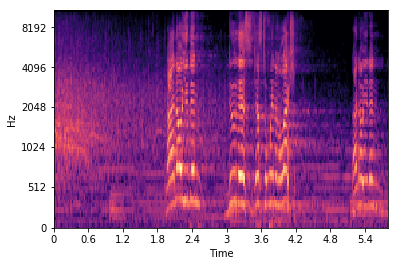

In [6]:
face_path = Openface(yt_video_id=yt_video_ids[0], data_dir=data_dir).output().path
# mel_path = MelSpectrogram(yt_video_id=yt_video_ids[0], data_dir=data_dir, hop_duration=1/30).output().path
mel_path = MelSpectrogram(yt_video_id=yt_video_id, data_dir=data_dir, hop_length=540, sampling_rate=16200, n_fft=540).output().path
wav_path = DownloadYoutubeAudio(yt_video_id=yt_video_ids[0], data_dir=data_dir).output().path
melspec = np.load(mel_path)
face = pd.read_csv(face_path)
y,sr = librosa.core.load(wav_path, sr=16200, mono=True)
# wav_melspec = librosa.feature.melspectrogram(y, n_fft=2048, hop_length=int(0.033*16000))
# y = y[:-(16200-4522)] # 16200
# y = y[:-(16000-4467)]

print(y.shape, y.shape[0]/sr, len(face) * (1./30.))

print('a', (166 * sr) - y.shape[0])
hop_length = round((1./30.) * sr)
print(round(hop_length))
spectrogram = np.abs(
    librosa.stft(
        y=y,
        n_fft=hop_length,
        hop_length=hop_length,
        center=False,
        window='hann'
    )
    ** 2
)

melspectrogram = librosa.feature.melspectrogram(
    S=spectrogram, n_mels=80
)

D = librosa.power_to_db(melspectrogram)
print(D.shape)
print(melspectrogram.shape, spectrogram.shape, (166*30) - len(face), len(face[:-20]), melspec.shape, len(face))
# librosa.display.specshow(spectrogram[:, 500:750], y_axis='log', x_axis='time')
librosa.display.specshow(D[:,500:750], y_axis='mel', x_axis='time')
plt.show()